In [1]:
import numpy as np
import pandas as pd
import os
import time
import json
import tensorflow as tf
import random
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD  # Add this import
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from IPython import display 

In [2]:
def set_random_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_random_seed(42)

In [3]:

def load_data(csv_file):
    df_data  = pd.read_csv(csv_file)
    return df_data[["x1", "x2"]].values, df_data[["y"]].values.flatten()
def load_dataset(csv_train = "./data/train.csv",
                 csv_valid = "./data/valid.csv",
                 csv_test  = "./data/test.csv"):
    # test
    x_test, y_test = load_data(csv_test)

    #train
    x_train, y_train = load_data(csv_train)

    #valid
    x_valid, y_valid = load_data(csv_valid)

    return x_train, y_train, x_valid, y_valid, x_test, y_test
def visualize_dataset(x, y, color = "green", title = "Training Data\n", ax = None):
    if ax is None:
        plt.figure(figsize=(16, 6))
        ax = plt.subplot(1,2,1, projection='3d')
    # if

    surf = ax.scatter(x[:,0], x[:,1], y, c = color)
    ax.set_frame_on
    ax.set_xlabel('x1', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_ylabel('x2', labelpad = 5, fontdict=dict(fontsize = 14))
    ax.set_zlabel("y", labelpad = 5, fontdict=dict(fontsize = 14))
    plt.legend(['Gaussian values'])
    plt.title(title, fontdict=dict(fontsize = 20))

In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_dataset(csv_train="./data/train.csv", csv_valid="./data/valid.csv", csv_test="./data/test.csv")

# Some Function

In [5]:
def visualize_logs(visualize_data, group_data, figsize = (10, 5), is_show = True, label_size = 12, title_size = 16, save_path = None):
    """
    visualize_data = df_logs[50:].to_dict(orient='list')
    group_data     = [{"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                       "title": "Error at Epoch {epoch}: {val_mean_squared_error:.4f}\n",
                       "style": "min"},
                      {"x": "epoch", "y": ["loss", "val_loss"],
                       "title": "Loss at Epoch {epoch}: {val_loss:.4f}\n",
                       "style": "min"}]
    figsize        = (10, 5)
    visualize_logs(visualize_data, group_data, figsize)
    """
    import matplotlib.ticker as ticker
    import matplotlib.pyplot as plt, numpy as np

    fig = plt.figure(figsize=figsize)
    for idx, group in enumerate(group_data):
        x_axis_name, y_axis_names, title, style = group["x"], group["y"], group["title"], group["style"]
        x_values = visualize_data[x_axis_name]
        end_logs = dict([(x_axis_name, x_values[-1])])

        ax = plt.subplot(1, len(group_data), idx%len(group_data) + 1)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        for y_axis_name in y_axis_names:
            y_values = visualize_data[y_axis_name]
            if style is not None and style != "":
                y_values = []
                for i in range(len(visualize_data[y_axis_name])):
                    if style == "median":
                        y_values.append(np.median(visualize_data[y_axis_name][:i+1]))
                    elif style == "avg":
                        y_values.append(np.average(visualize_data[y_axis_name][:i+1]))
                    elif style == "max":
                        y_values.append(np.max(visualize_data[y_axis_name][:i+1]))
                    elif style == "min":
                        y_values.append(np.min(visualize_data[y_axis_name][:i+1]))
            # if
            end_logs.update(dict([(y_axis_name, y_values[-1])]))
            ax.plot(x_values, y_values)
        pass
        title = title.format(**end_logs)

        ax.set_xlabel(x_axis_name, fontsize = label_size)
        ax.legend(y_axis_names, loc='upper left', fontsize = label_size)
        ax.set_title(title, fontsize = title_size)
    # for

    if save_path is not None:
        save_dir = os.path.dirname(save_path)
        if save_dir != "" and os.path.exists(save_dir) == False: os.makedirs(save_dir)
        fig.savefig(save_path)
    # if

    if is_show == True:
        plt.show()
        return None
    return fig
# visualize_logs
def summarize_diagnostics(history):
    # plot loss
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title("Mean Squared Error")
    plt.plot(history.history["loss"], color="blue", label="train")
    plt.plot(history.history['val_loss'], color="orange", label='test')
# summarize_diagnostics

# Network Structure

In [6]:
def build_model():
    inp = Input(shape=(2,), name='Input')
    x = Dense(units=20, activation='relu', name='HiddenLayer')(inp)
    output_label = Dense(units=1, activation='linear', name='Output')(x)
    model = Model(inputs=inp, outputs=output_label)
    model.summary()
    return model

# Experiment Epoch

## Model

In [7]:
model = build_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

## Training

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ HiddenLayer (Dense)             │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

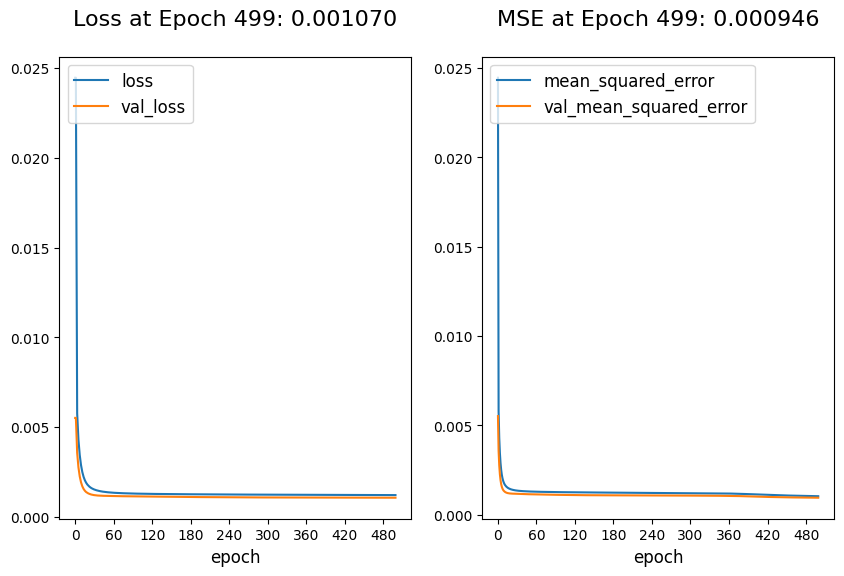

> training time is 3.5107 minutes


In [8]:
K.clear_session()
model = build_model()

# OPTIMIZATION
model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.01), metrics=['mean_squared_error'])

# CALLBACKS
callbacks = []

# + ModelCheckPoint
save_dir = "./data/model/train_01"
template_name= "funcApxm_model_01_{epoch:02d}_{val_loss:.3f}_val_acc-{val_mean_squared_error:.3f}.keras"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)
modekcheckpoint_callback = ModelCheckpoint(filepath=os.path.join(save_dir, template_name),
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto',  # min, max, auto
    save_freq='epoch'  # Replaces 'period', saves every epoch
                                          )
callbacks.append(modekcheckpoint_callback)

# + Early Stopping
earlystopping_callback = EarlyStopping(monitor='val_loss', patience= 10)
callbacks.append(earlystopping_callback)


# + Visualize logs
review_logs = {}
def custom_on_epoch_end(self, epoch, logs, **kwargs):
    review_logs = kwargs["review_logs"]
    if epoch == 0:
        review_logs["epoch"] = [epoch]
        for key in logs.keys(): review_logs[key] = [logs[key]]
    # if
    review_logs["epoch"].append(epoch)
    for key in logs.keys(): review_logs[key].append(logs[key])

    visualize_data = review_logs
    group_view     = [{"x": "epoch", "y": ["loss", "val_loss"],
                       "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                       "style": "median"},
                      {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                       "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                       "style": None}
                     ]
    fig = visualize_logs(visualize_data, group_view, figsize = (10, 6), is_show = False, save_path = os.path.join("./data/model/train_01", "logs.png"))
    plt.close()
    if epoch == 0:
        display.display(fig, display_id="logs")
    else:
        display.update_display(fig, display_id="logs")
    pass
# custom_on_epoch_end

custom_callbacks = LambdaCallback()
custom_callbacks.on_epoch_end = lambda epoch, logs: custom_on_epoch_end(custom_callbacks, epoch, logs, review_logs = review_logs)
callbacks.append(custom_callbacks)

# TRAINING
batch_size = 128
epochs = 500

starting_time = time.time()
history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks = callbacks,
                    verbose = 0)
print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))



In [9]:
# Sau khi training hoàn tất, lưu kết quả cuối cùng
group_view = [{"x": "epoch", "y": ["loss", "val_loss"],
                       "title": "Loss at Epoch {epoch}: {val_loss:.6f}\n",
                       "style": "median"},
                      {"x": "epoch", "y": ["mean_squared_error", "val_mean_squared_error"],
                       "title": "MSE at Epoch {epoch}: {val_mean_squared_error:.6f}\n",
                       "style": None}
                     ]

# Đường dẫn lưu kết quả
final_save_path = "./epoch/final_results.png"
os.makedirs("./epoch", exist_ok=True)  # Tạo thư mục ./epoch nếu chưa tồn tại

# Vẽ và lưu biểu đồ
fig = visualize_logs(
    review_logs, group_view, figsize=(10, 6), is_show=False, save_path=final_save_path
)
plt.close()

print(f"> Final visualization saved at {final_save_path}")


> Final visualization saved at ./epoch/final_results.png


## Evaluating

In [10]:
epoch_opt = np.argmin(history.history["val_mean_squared_error"])
print(epoch_opt)

499


In [11]:
save_name = template_name.format(epoch = epoch_opt + 1, 
                 val_mean_squared_error = history.history["val_mean_squared_error"][epoch_opt], 
                 val_loss= history.history["val_loss"][epoch_opt])
save_path = os.path.join(save_dir, save_name)
save_path

'./data/model/train_01\\funcApxm_model_01_500_0.001_val_acc-0.001.keras'

In [12]:
from keras.models import load_model

model = load_model(save_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MSE:', score[1])


Test loss: 0.001052991719916463
Test MSE: 0.001052991719916463


In [13]:
# Ngưỡng giảm MSE nhỏ nhất
tolerance = 1e-7
patience = 10  # Số epoch liên tiếp không cải thiện

# Lấy giá trị MSE từ history
val_mse = np.array(history.history["val_mean_squared_error"])

# Tính độ chênh lệch MSE giữa các epoch liên tiếp
mse_diff = np.abs(np.diff(val_mse))

# Xác định điểm bão hòa
saturation_epoch = None
for i in range(len(mse_diff)):
    # Nếu chênh lệch nhỏ hơn tolerance và tiếp tục không cải thiện trong "patience" epoch
    if mse_diff[i] < tolerance and all(d < tolerance for d in mse_diff[i:i+patience]):
        saturation_epoch = i + 1  # Epoch bắt đầu từ 1
        break

if saturation_epoch:
    mse_at_saturation = val_mse[saturation_epoch - 1]  # Lấy giá trị MSE tại epoch (trừ 1 vì index bắt đầu từ 0)
    print(f"Điểm bão hòa phát hiện tại epoch: {saturation_epoch}")
    print(f"Validation MSE tại điểm bão hòa: {mse_at_saturation:.8f}")
else:
    print("Không tìm thấy điểm bão hòa rõ ràng.")


Điểm bão hòa phát hiện tại epoch: 156
Validation MSE tại điểm bão hòa: 0.00108312


In [14]:

save_name = template_name.format(epoch = saturation_epoch, 
                 val_mean_squared_error = history.history["val_mean_squared_error"][epoch_opt], 
                 val_loss= history.history["val_loss"][epoch_opt])
save_path = os.path.join(save_dir, save_name)
save_path

'./data/model/train_01\\funcApxm_model_01_156_0.001_val_acc-0.001.keras'

In [15]:

model = load_model(save_path)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test MSE:', score[1])


Test loss: 0.0012116568395867944
Test MSE: 0.0012116568395867944


## Report